In [1]:
from IPython import get_ipython
get_ipython().magic('reset -sf') 

In [2]:
import tensorflow as tf
gpu_options = tf.GPUOptions(allow_growth=True, per_process_gpu_memory_fraction=0.1)
s = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import load_digits
from tensorflow.examples.tutorials.mnist import input_data

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [3]:
N = 10

## Let's start

In [4]:
def sum_squares(N):
    return np.sum(np.dot(np.arange(0, N), np.arange(0, N)))

In [5]:
%%time
sum_squares(10**8)

CPU times: user 645 ms, sys: 830 ms, total: 1.48 s
Wall time: 1.81 s


662921401752298880

# Quest №1
Implement a function that computes a mean squared error of two input vectors
Your function has to take 2 vectors and return a single number

In [6]:
def compute_mse(X, Y):
     return np.square(X - Y).mean()

In [7]:
X = np.random.rand(N)
Y = np.random.rand(N)

print(X, Y, end='\n')
compute_mse(X, Y)

[ 0.02116622  0.04265788  0.10942441  0.30549943  0.08726278  0.34303591
  0.27737433  0.33170542  0.2460332   0.120123  ] [ 0.33342144  0.80864777  0.11175198  0.38511566  0.07866573  0.3074944
  0.03247372  0.62789437  0.34648361  0.93746765]


0.1517771877233168

In [8]:
from sklearn.metrics import mean_squared_error

for n in [1,5,10,10**3]:
    
    elems = [np.arange(n),np.arange(n,0,-1), np.zeros(n),
             np.ones(n),np.random.random(n),np.random.randint(100,size=n)]
    
    for el in elems:
        for el_2 in elems:
            true_mse = np.array(mean_squared_error(el,el_2))
            my_mse = compute_mse(el,el_2)
            if not np.allclose(true_mse,my_mse):
                print('Wrong result:')
                print('mse(%s,%s)' % (el,el_2))
                print("should be: %f, but your function returned %f" % (true_mse,my_mse))
                raise ValueError

print("All tests passed")

All tests passed


## Variables

In [9]:
shared_vector_1 = tf.Variable(initial_value=np.ones(5))

s.run(tf.global_variables_initializer())

print("initial value", s.run(shared_vector_1))
s.run(shared_vector_1.assign(np.arange(5)))

print("new value", s.run(shared_vector_1))

initial value [ 1.  1.  1.  1.  1.]
new value [ 0.  1.  2.  3.  4.]


## Graphs

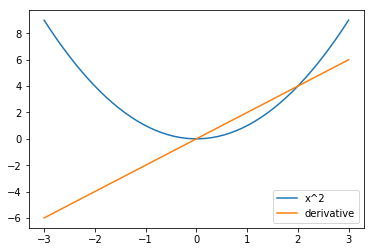

In [10]:
my_scalar = tf.placeholder('float32')

scalar_squared = my_scalar**2

derivative = tf.gradients(scalar_squared, my_scalar)[0]

x = np.linspace(-3,3)
x_squared, x_squared_der = s.run([scalar_squared,derivative],
                                 {my_scalar:x})

plt.plot(x, x_squared,label="x^2")
plt.plot(x, x_squared_der, label="derivative")
plt.legend();

## Why that rocks

In [11]:
my_vector = tf.placeholder('float32',[None])
print(my_vector, my_scalar)

weird_psychotic_function = (tf.reduce_mean((my_vector+my_scalar)**(1+tf.nn.moments(my_vector,[0])[1]) + 
                            1./ tf.atan(my_scalar))/(my_scalar**2 + 1) +
                            0.01*tf.sin(2*my_scalar**1.5)*(tf.reduce_sum(my_vector)* my_scalar**2)*tf.exp((my_scalar-4)**2)/
                            (1+tf.exp((my_scalar-4)**2))*(1.-(tf.exp(-(my_scalar-4)**2))/
                            (1+tf.exp(-(my_scalar-4)**2)))**2)

print(weird_psychotic_function)

Tensor("Placeholder_1:0", shape=(?,), dtype=float32) Tensor("Placeholder:0", dtype=float32)
Tensor("add_6:0", dtype=float32)


In [12]:
der_by_vector = tf.gradients(weird_psychotic_function, my_vector)
der_by_scalar = tf.gradients(weird_psychotic_function, my_scalar)

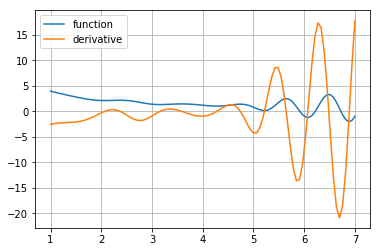

In [13]:
scalar_space = np.linspace(1, 7, 100)

y = [s.run(weird_psychotic_function, {my_scalar:x, my_vector:[1, 2, 3]})
     for x in scalar_space]

plt.plot(scalar_space, y, label='function')

y_der_by_scalar = [s.run(der_by_scalar, {my_scalar:x, my_vector:[1, 2, 3]})
     for x in scalar_space]

plt.plot(scalar_space, y_der_by_scalar, label='derivative')
plt.grid()
plt.legend();

## Optimizers

In [14]:
y_guess = tf.Variable(np.zeros(2,dtype='float32'))
y_true = tf.range(1,3,dtype='float32')

loss = tf.reduce_mean((y_guess - y_true + tf.random_normal([2]))**2) 

optimizer = tf.train.MomentumOptimizer(0.01,0.9).minimize(loss,var_list=y_guess)

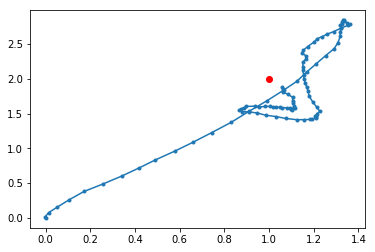

In [15]:
from IPython.display import clear_output

s.run(tf.global_variables_initializer())

guesses = [s.run(y_guess)]

for _ in range(100):
    s.run(optimizer)
    guesses.append(s.run(y_guess))
    
    clear_output(True)
    plt.plot(*zip(*guesses),marker='.')
    plt.scatter(*s.run(y_true),c='red')
    plt.show()

## Logistic regression example

In [16]:
mnist = load_digits(2)

X, y = mnist.data, mnist.target
print(np.shape(X), np.shape(y))

(360, 64) (360,)


In [17]:
def predict_function(X):
    return tf.nn.softmax(X)

In [18]:
def train_function(input_X, X_train, input_Y, y_train):
    init_g = tf.global_variables_initializer()
    init_l = tf.local_variables_initializer()
    with tf.Session() as sess:
        sess.run(init_g)
        sess.run(init_l)
        for i in range(5):
            optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(loss)
            _, loss_i = sess.run([optimizer, loss], feed_dict={input_X: X_train, input_Y: y_train})
        w_value, loss = sess.run([w, loss])

In [19]:
def predict_fun(X, w, b):
    print('predict_fun: ', np.shape(X), np.shape(w), np.shape(b), np.shape(tf.matmul(X, w) + b))
    return tf.matmul(X, w) + b

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

print(np.shape(X_train), np.shape(X_test), np.shape(y_train), np.shape(y_test))

print(y_train)

y_train = np.reshape(y_train, (270, 1))

(270, 64) (90, 64) (270,) (90,)
[0 0 1 1 1 1 1 0 0 0 1 1 0 0 0 1 1 1 1 0 1 1 0 1 1 1 0 1 0 1 1 0 1 0 0 0 0
 0 0 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 0 1 0 1 1 0 1 0 0 0 1 1
 1 1 1 0 0 0 0 1 1 1 0 0 1 1 0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 0 1 1 0 1 1 1 1
 1 0 0 1 1 0 1 1 0 0 1 1 0 1 0 1 0 0 0 0 1 0 0 0 0 1 1 1 1 1 0 0 1 0 0 1 0
 1 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 1 1 1 0 1 0 0 0 0 1 0 1 1 1 0
 0 0 0 1 1 0 1 1 1 0 0 1 1 1 1 1 1 0 1 0 1 0 0 0 1 1 0 0 0 0 0 1 0 1 1 0 1
 1 1 1 1 1 1 1 0 0 0 1 0 1 1 1 0 1 1 0 0 1 0 1 0 0 0 1 0 1 1 1 0 0 1 1 1 0
 0 0 1 0 0 1 1 1 0 0 0]


predict_fun:  (270, 64) (64, 1) (1, 1) (270, 1)
hmmm:  (270, 1) (270, 1)
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

epoch:  0 Tensor("Mean_2:0", shape=(), dtype=float32)
loss at iter 0:0.0000
epoch:  1 Tensor("Mean_2:0", shape=(), dtype=float32)
loss at iter 1:0.0000
epoch:  2 Tensor("Mean_2:0", shape=(), dtype=float32)
loss at iter 2:0.0000
epoch:  3 Tensor("Mean_2:0", shape=(), dtype=float32)
loss at iter 3:0.0000
epoch:  4 Tensor("Mean_2:0", shape=(), dtype=float32)
loss at iter 4:0.0000
resulting weights:


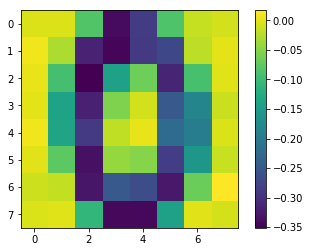

In [21]:
learning_rate = 0.01
batch_size = 270
n_epochs = 25

input_X = tf.placeholder(tf.float32, [batch_size, 64])
input_Y = tf.placeholder(tf.float32, [batch_size, 1])
weights = tf.Variable(tf.random_normal(shape=[64, 1], stddev=0.01), name="weights")
b = tf.Variable(tf.zeros([1, 1]), name="bias")

predicted_y = predict_fun(input_X, weights, b)

print('hmmm: ', np.shape(predicted_y), np.shape(input_Y))

entropy = tf.nn.softmax_cross_entropy_with_logits(logits=predicted_y, labels=input_Y)
loss = tf.reduce_mean(entropy)

optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(loss)

# loss = np.mean(-(y_train * tf.log(predicted_y) + (1 - y_train) * tf.log(1 - predicted_y)))

n_batches = 10
init_g = tf.global_variables_initializer()
init_l = tf.local_variables_initializer()

with tf.Session() as sess:
    sess.run(init_g)
    sess.run(init_l)
    
    for i in range(5):
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(loss)
        print('epoch: ', i, loss)

        # for _ in range(n_batches):
        _, loss_i = sess.run([optimizer, loss], feed_dict={input_X: X_train, input_Y: y_train})

        print("loss at iter %i:%.4f" % (i, loss_i))

        # print("train auc:",roc_auc_score(y_train, predict_fun(X_train, weights, b)))
        # print("test auc:",roc_auc_score(y_test, predict_fun(X_test, weights, b)))

    print ("resulting weights:")
    plt.imshow(weights.eval().reshape([8,8]))
    plt.colorbar()